# wMed flood Stage 1 : Added background potential energy (BPE) by inflow

## </span>(Until the WMed level reaches Sicily sill level)</span>


We consider the western and eastern Mediterranean basins (wMed and eMed) to be composed of 1-meter thick layers from bottom towards the surface.

This domain is then used to calculate the added BPE during stage 1 of the flood (and stage 2 & 3)


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline 
import math
from PIL import Image

## Upload data files here

Rise of the basin levels exported from Zanclean flooding model is used to calculate the daily addition of BPE by flood discharge.

In [6]:
SLrise_Stage1 = np.loadtxt(fname="SLrise_toSicily.txt")  # Daily rise of sea-level during stage 1
SLrise_Stage1 = SLrise_Stage1.tolist()
Hypsometry_wMed = np.loadtxt(fname="Hypsometry_wMed_CalcBPE.txt")   # Reconstructed wMed hypsometry


##  Setting parameters

In [7]:
rho_SW = 1027 # Sea-water density [kg m^-3]
g = 9.81      # Acceleration due to gravity [m s^-2]

SLarray =(Hypsometry_wMed[:,0])        # Text file column 1 gives basin depth
Area    =(Hypsometry_wMed[:,1])*10**12 # Text file column 2 gives area with depth

<img src="https://www.dropbox.com/s/49iuqo1vq8b2gut/BPE_Calc_concept.jpg?raw=1" width="806.4" height="453.6" >


## <span style='color:Red'> Equations  </span>

Consider the wMed basin during the flood to be composed of 1-m thick layers ($dz$).
Base level prior to the flood, $z = 0$.

Potential energy (PE) contribution by a single layer $Li$ of thickness $dz$ with brine density $\rho_b$ and area $Ai$ can be written as:
$$ PE_i = A_i\rho_b g [-dz(i-0.5)] dz$$

where $g$ is acceleration due to gravity.

Therefore, total PE of the brine column can be given as:

$$ PE_{brine} = \sum_{i=1}^{n} {A_i\rho_b g [-dz(i-0.5)] dz}$$

If the thickness of sea-water layer flooded in to the basin is $y$, and the sea-water density is $\rho_s$, 

Added BPE by the inflow is: $$ PE_{Added} = \frac{(A_i\rho_s g y^{2})}{2} $$

Total PE of the system can be written as:$$ PE_{total} =  PE_{Added} + PE_{brine}$$

$$ PE_{total} = \frac{(A_i\rho_s g y^{2})}{2} -\sum_{i=1}^{n} {A_i\rho_b g [(i-0.5)] dz^{2}}$$

### Calculating added BPE (stage 1):

In following sections, added BPE per day during the stage 1 will be calculated.

### We consider 3 possible modes of sea-level rise in the system (see the diagrams)

<img src="https://www.dropbox.com/s/nfhguleq75v1oq5/Added%20BPE%20Case1_2_3.jpg?raw=1" width="567.2" height="569">

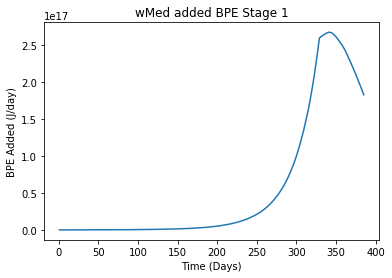

In [9]:
SL1 = SLrise_Stage1[0]  # Present-day sea-level
SL2 = SLrise_Stage1[1]  # Next day sea-level

BPE_sum = [0]  # Array to store total BPE for plotting
t = 1         # Starting time
time=[]       # Array to store time [days]

while SL1>0:
    
    SL1 = SLrise_Stage1[SLrise_Stage1.index(SL1)+1]
    
    if SL1 == SLrise_Stage1[-1]:
        break
        
    SL2 = SLrise_Stage1[SLrise_Stage1.index(SL2)+1]

    # Arrays used for calculations, see below
    y    = []
    y0   = []
    yi   = []
    p    = []
    y00  = []
    yii  = []
    Product_VolumeHt = [] # product of cell volume and head difference
    
    SL_presentDay    = math.trunc(SL1)
    SL_nextDay       = math.trunc(SL2)+1
    SL2_truncated    = math.trunc(SL2)
    SL_Gap1          = SL1-SL_presentDay
    SL_Gap2          = SL_nextDay-SL2
    
    #print (SL_presentDay,SL_nextDay,SL2_truncated, SL_Gap1, SL_Gap2)
    
    for i,j in zip(SLarray,Area):
        
        if i<SL1 and i>SL2:
            
            y.append(i)
            p.append(j)

            for ii,jj in zip(y,p):
                
                product = (SL1-ii+0.5)*jj  
                
            Product_VolumeHt.append(product) 
            
    BPE_completeCells = np.sum(Product_VolumeHt)*g*rho_SW
    

    
    for i0,j0 in zip(SLarray,Area):
        
        if i0 == (SL_presentDay+1):
            
            y0.append(i0)
            y00.append(j0)
         
        #CASE 1
        BPEBot_case1 = np.array(y00)*rho_SW*0.5*g*(SL_Gap1)**2
        # CASE 2 where SL_nextDay = SL_presentDay
        BPEBot_case2 = np.array(y00)*rho_SW*0.5*g*((SL_Gap1)**2)

        
    for ii,ji in zip(SLarray,Area):
        
        if ii == SL_nextDay:
            
            yi.append(ii)
            yii.append(ji)
            
        #Case1    
        BPETop_case1    = np.array(yii)*rho_SW*g*0.5*((2*(SL1-SL2)*(SL2-SL2_truncated))+(SL2-SL2_truncated)**2)
        #Case2 
        BPETop_case2    = np.array(yii)*rho_SW*g*0.5*((2*SL_Gap1*SL_Gap2)+SL_Gap2**2)
        

    if SL_presentDay-SL2_truncated>1:    # CASE 1 (Sealevel rise across several layers)
        BPETotal = (BPE_completeCells + BPEBot_case1 - BPETop_case1)     
        
    if SL_presentDay-SL2_truncated ==1:  # CASE 2 (Sealevel rise across 2 consecutive layers)
        
        BPETotal = BPEBot_case2 + BPETop_case2
        
    if SL_presentDay==SL2_truncated:     # CASE 3 (Sealevel rise within a layer of 1 m)
        
        BPETotal = ((1-SL_Gap1-SL_Gap2)**2)*rho_SW*g*0.5*np.array(yii) #- Sign doen's matter as squared is positive
        

        
    BPE_sum.append(BPETotal)
    time.append(t)
    t=t+1       
    #print(y00, BPEBot_case1, SL_Gap1, SL_Gap2, SL_presentDay, SL_nextDay, BPETop_case1)
    #print(yii)
    #print(y)
    #print(BPE_completeCells, t)

    
plt.figure()
plt.title('wMed added BPE Stage 1')
plt.ylabel('BPE Added (J/day)')
plt.xlabel('Time (Days)')
plt.plot(time,BPE_sum[1:])

np.savetxt("wMed_added_BPE_Stage1.txt", np.array(BPE_sum), fmt="%s")
    